# ltu-ili jupyter interface
This is a tutorial for using the ltu-ili inference framework in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## Toy NPE
This example attempts to infer 3 unknown parameters from a 20-dimensional 1D data vector using amortized posterior inference. We train the models from a simple synthetic catalog. This tutorial mirrors the same configuration as in [examples/toy_sbi.py](../examples/toy_sbi.py), but demonstrates how one would interact with the inference pipeline in a jupyter notebook.

In [2]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

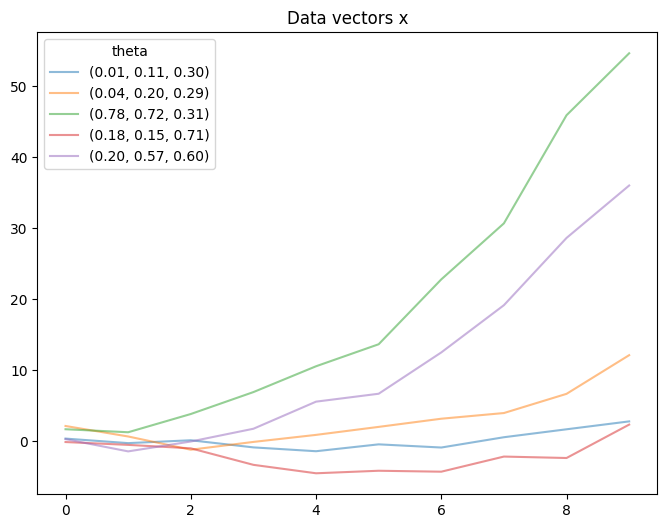

In [3]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

The SBIRunner object will handle all of the data normalization and model training for us. We just need to provide it with:
- our parameter prior
- our inference type (SNPE/SNLE/SNRE)
- our desired neural network architecture
- our training hyperparameters

On the backend, it does a validation split among the provided training data, trains the neural networks with an Adam optimizer, and enforces an early stopping criterion to prevent overfitting. All the parameters of these processes can be independently configured.

In [4]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
repeats_maf = 2 # not to have to duplicate code for a large ensemble of identical architectures
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5, repeats = repeats_maf),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [5]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE


INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 20

 Training neural network. Epochs trained: 40

 Training neural network. Epochs trained: 60

 Training neural network. Epochs trained: 80

 Training neural network. Epochs trained: 100

 Training neural network. Epochs trained: 120

 Training neural network. Epochs trained: 141

 Training neural network. Epochs trained: 162

 Training neural network. Epochs trained: 183

 Training neural network. Epochs trained: 205

 Training neural network. Epochs trained: 226

 Training neural network. Epochs trained: 248

 Training neural network. Epochs trained: 270

 Training neural network. Epochs trained: 292

 Training neural network. Epochs trained: 314

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 9

 Training neural network. Epochs trained: 29

 Training neural network. Epochs trained: 49

 Training neural network. Epochs trained: 69

 Training neural network. Epochs trained: 89

 Training neural network. Epochs trained: 108

 Training neural network. Epochs trained: 128

 Training neural network. Epochs trained: 148

 Training neural network. Epochs trained: 168

 Training neural network. Epochs trained: 189

 Training neural network. Epochs trained: 209

 Training neural network. Epochs trained: 230

 Training neural network. Epochs trained: 251

 Training neural network. Epochs trained: 273

 Training neural network. Epochs trained: 294

 Training neural network. Epochs trained: 315

 Training neural network. Epochs trained: 336

 Neural network successfully converged after 354 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 48

 Training neural network. Epochs trained: 95

 Training neural network. Epochs trained: 143

 Training neural network. Epochs trained: 192

 Training neural network. Epochs trained: 240

 Training neural network. Epochs trained: 290

 Training neural network. Epochs trained: 339

 Training neural network. Epochs trained: 388

 Training neural network. Epochs trained: 437

INFO:root:It took 10.367932081222534 seconds to train models.


 Neural network successfully converged after 455 epochs.

Here, the output of the runner is a posterior model and a log of training statistics. The posterior model is a [NeuralPosteriorEnsemble](https://github.com/mackelab/sbi/blob/6c4fa7a6fd254d48d0c18640c832f2d80ab2257a/sbi/utils/posterior_ensemble.py#L19) model and automatically combines samples and probability densities from its component networks.

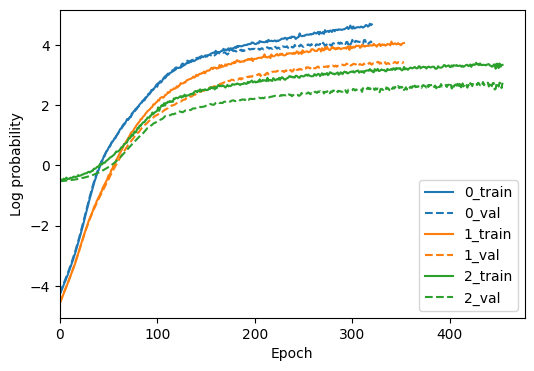

In [6]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(-1.0*np.array(m['training_loss']), ls='-', label=f"{i}_train", c=c[i])
    ax.plot(-1.0*np.array(m['validation_loss']), ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

We now can take the posterior model learned by the InferenceRunner and use it to make predictions on new data. First, we consider generating samples from a posterior conditioned on a single observation.

In [7]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 301 posterior samples:   0%|          | 0/301 [00:00<?, ?it/s]

Drawing 117 posterior samples:   0%|          | 0/117 [00:00<?, ?it/s]

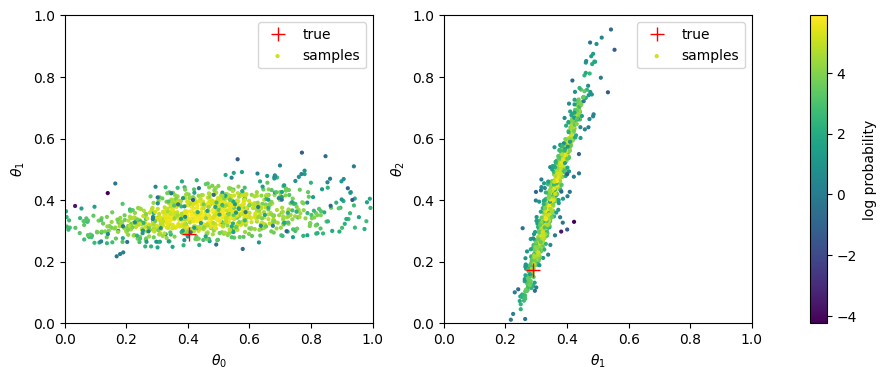

In [8]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 556 posterior samples:   0%|          | 0/556 [00:00<?, ?it/s]

Drawing 299 posterior samples:   0%|          | 0/299 [00:00<?, ?it/s]

Drawing 145 posterior samples:   0%|          | 0/145 [00:00<?, ?it/s]

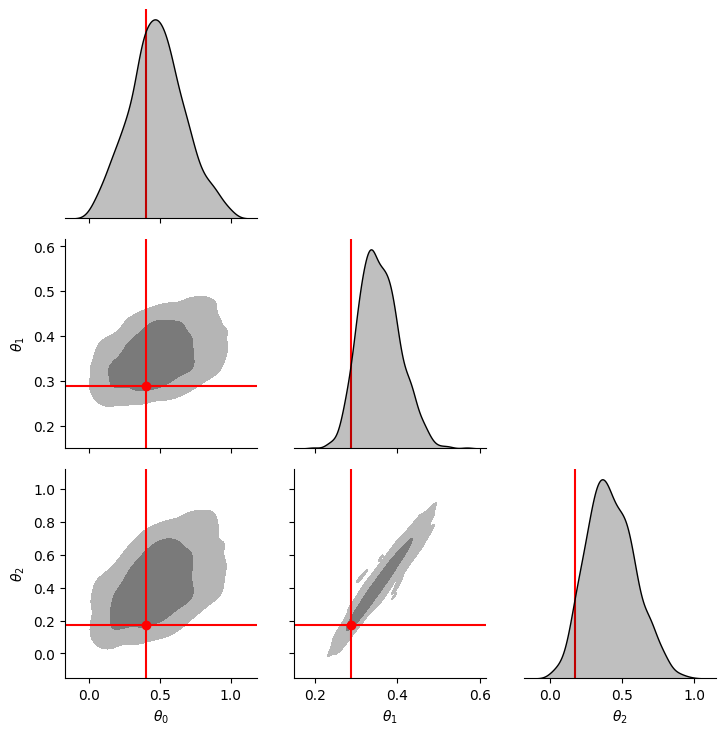

In [9]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

The above plot shows the 68% and 95% confidence intervals of our ensemble posterior prediction. This shows that our model posterior is consistent with the true parameters for one datum. **However, how do we know that our model is good at predicting the full dataset?**


We can use the `PosteriorCoverage` object to measure various statistics about the posterior's performance on the whole dataset. Below, we ask `PosteriorCoverage` to compute:
 - `"coverage"`: the marginal, empirical coverage (P-P plot) of the model posteriors
 - `"histogram"`: the histogram of posterior ranks
 - `"predictions"`: classic true vs. predictions plots for all data points, with error bars
 - `"tarp"`: the multivariate, empirical coverage (P-P plot) of the model posteriors
 - `"logprob"`: the log probability of the true data under the model posterior

For explicit details on the definition and constructions of these plots, see Section 2.4 of [the LtU-ILI paper](https://arxiv.org/abs/2402.05137). The results of these metrics are shown, consecutively, in the output plots.

  0%|                                                                                                                                     | 0/200 [00:00<?, ?it/s]

  6%|██████▊                                                                                                                    | 11/200 [00:00<00:01, 103.78it/s]

 11%|█████████████▌                                                                                                             | 22/200 [00:00<00:01, 106.22it/s]

 17%|████████████████████▉                                                                                                      | 34/200 [00:00<00:01, 107.88it/s]

 22%|███████████████████████████▋                                                                                               | 45/200 [00:00<00:01, 107.19it/s]

 28%|██████████████████████████████████▋                                                                                         | 56/200 [00:00<00:01, 99.72it/s]

 34%|█████████████████████████████████████████▌                                                                                  | 67/200 [00:00<00:01, 94.16it/s]

 40%|████████████████████████████████████████████████▌                                                                          | 79/200 [00:00<00:01, 100.05it/s]

 45%|███████████████████████████████████████████████████████▎                                                                   | 90/200 [00:00<00:01, 100.54it/s]

 51%|██████████████████████████████████████████████████████████████▏                                                           | 102/200 [00:00<00:00, 103.61it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                     | 113/200 [00:01<00:00, 96.03it/s]

 62%|████████████████████████████████████████████████████████████████████████████▎                                              | 124/200 [00:01<00:00, 98.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▍                                        | 134/200 [00:01<00:00, 97.94it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████                                 | 146/200 [00:01<00:00, 102.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▊                          | 157/200 [00:01<00:00, 103.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 168/200 [00:01<00:00, 101.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 179/200 [00:01<00:00, 103.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 190/200 [00:01<00:00, 101.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.53it/s]


INFO:root:Mean logprob: 4.4446e+00Median logprob: 4.5818e+00


  0%|                                                                                                                                     | 0/100 [00:00<?, ?it/s]

 17%|████████████████████▉                                                                                                      | 17/100 [00:00<00:00, 161.29it/s]

 35%|███████████████████████████████████████████                                                                                | 35/100 [00:00<00:00, 167.99it/s]

 52%|███████████████████████████████████████████████████████████████▉                                                           | 52/100 [00:00<00:00, 168.52it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 70/100 [00:00<00:00, 170.15it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 88/100 [00:00<00:00, 170.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 169.56it/s]

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


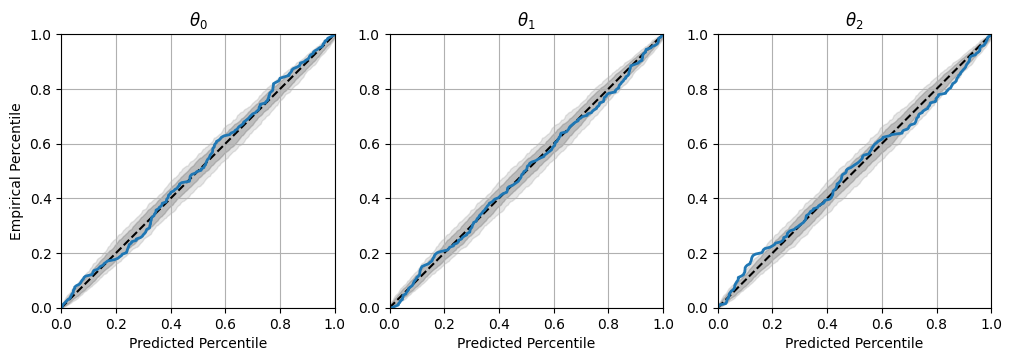

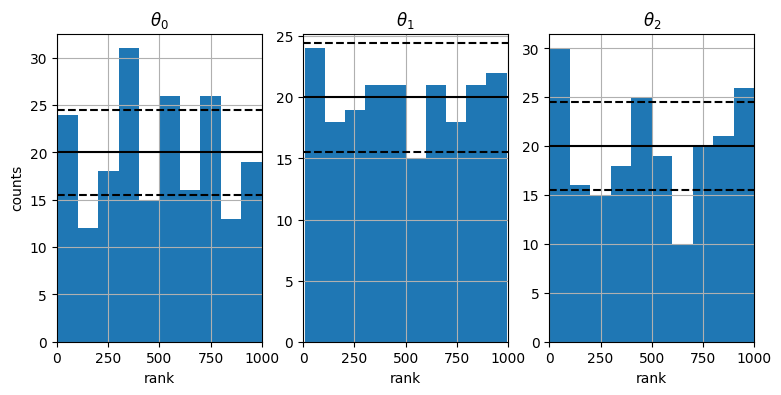

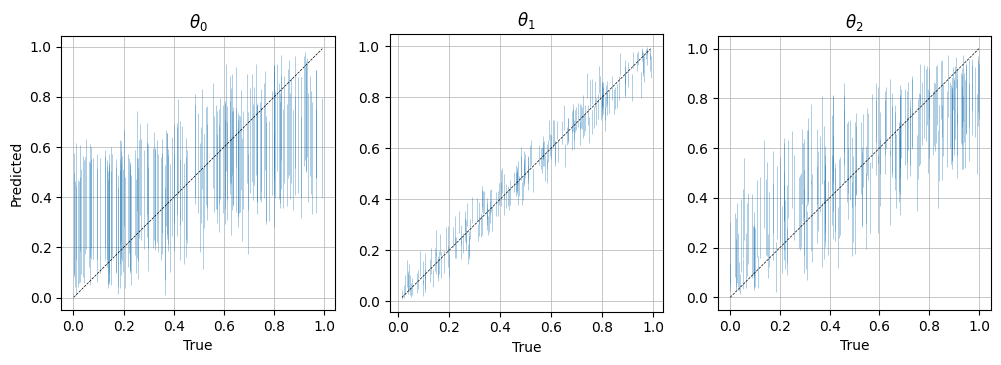

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


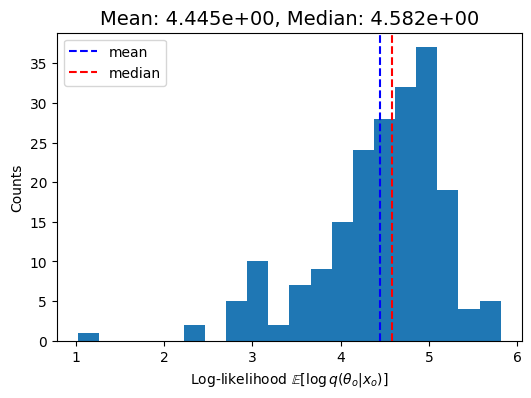

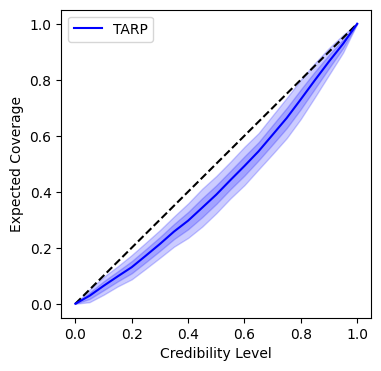

In [10]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

In the ensemble model, it looks like our posteriors are well-calibrated when evaluated on marginal distributions, but slightly negatively biased in the multivariate TARP coverage.

Instead of computing validation metrics on the entire ensemble, we can examine the properties of the individual component networks. This allows us to diagnose problems with individual training runs.

We first look at the predictions from each component posterior for a single data point. The following plot uses `PlotSinglePosterior` to overplot contours for the same prediction by different models.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

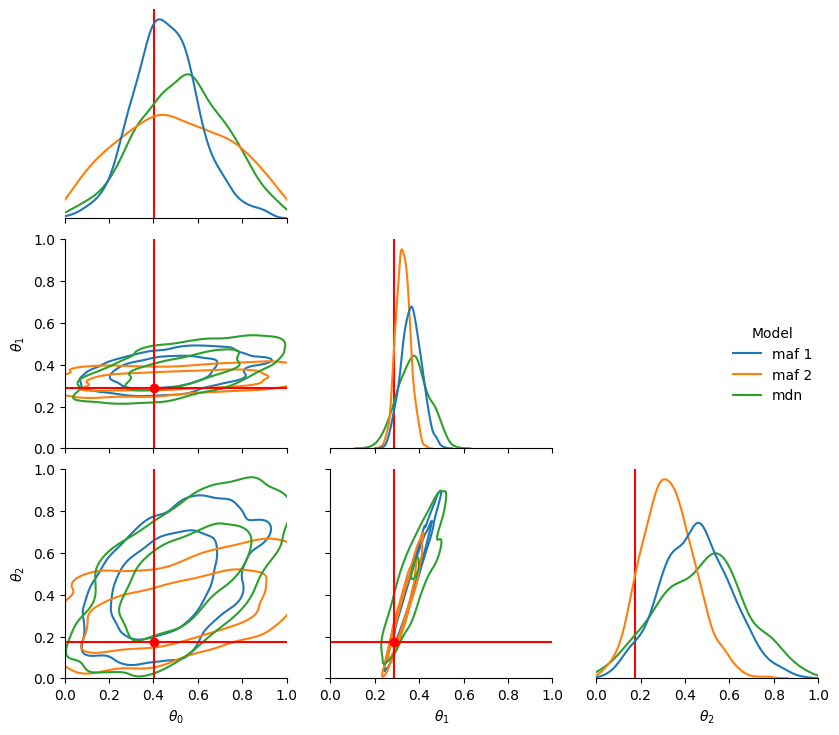

In [11]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x[ind], theta_fid=theta[ind],
    name='maf 1',
    lower=np.zeros(3), upper=np.ones(3)
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x_obs = x[ind], theta_fid=theta[ind],
    name='maf 2',
    lower=np.zeros(3), upper=np.ones(3),
    grid = fig
)

# overplot the posterior for model #3 (MDN)
fig = metric(
    posterior=posterior_ensemble.posteriors[2],
    x_obs = x[ind], theta_fid=theta[ind],
    name='mdn',
    lower=np.zeros(3), upper=np.ones(3),
    grid=fig  # overplot on the same figure
)

It looks like `mdn` models struggle to capture the strong degeneracies between $\theta_1$ and $\theta_2$, suggesting it is insufficiently flexible.

We can now compute separately `PosteriorCoverage` for each posterior in the ensemble.

  0%|                                                                                                                                     | 0/200 [00:00<?, ?it/s]

  7%|████████▌                                                                                                                  | 14/200 [00:00<00:01, 132.04it/s]

 14%|█████████████████▊                                                                                                         | 29/200 [00:00<00:01, 140.93it/s]

 22%|███████████████████████████                                                                                                | 44/200 [00:00<00:01, 140.58it/s]

 30%|████████████████████████████████████▎                                                                                      | 59/200 [00:00<00:01, 128.95it/s]

 36%|████████████████████████████████████████████▉                                                                              | 73/200 [00:00<00:01, 118.33it/s]

 43%|████████████████████████████████████████████████████▉                                                                      | 86/200 [00:00<00:00, 121.15it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                            | 101/200 [00:00<00:00, 128.12it/s]

 57%|█████████████████████████████████████████████████████████████████████▌                                                    | 114/200 [00:00<00:00, 117.57it/s]

 64%|██████████████████████████████████████████████████████████████████████████████                                            | 128/200 [00:01<00:00, 121.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████                                    | 141/200 [00:01<00:00, 120.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▏                          | 156/200 [00:01<00:00, 127.49it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████                   | 169/200 [00:01<00:00, 126.05it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 183/200 [00:01<00:00, 129.02it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 196/200 [00:01<00:00, 128.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 126.48it/s]

  0%|                                                                                                                                     | 0/100 [00:00<?, ?it/s]

 17%|████████████████████▉                                                                                                      | 17/100 [00:00<00:00, 165.27it/s]

 35%|███████████████████████████████████████████                                                                                | 35/100 [00:00<00:00, 169.69it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                         | 53/100 [00:00<00:00, 172.42it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▎                                   | 71/100 [00:00<00:00, 172.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 89/100 [00:00<00:00, 174.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 173.35it/s]

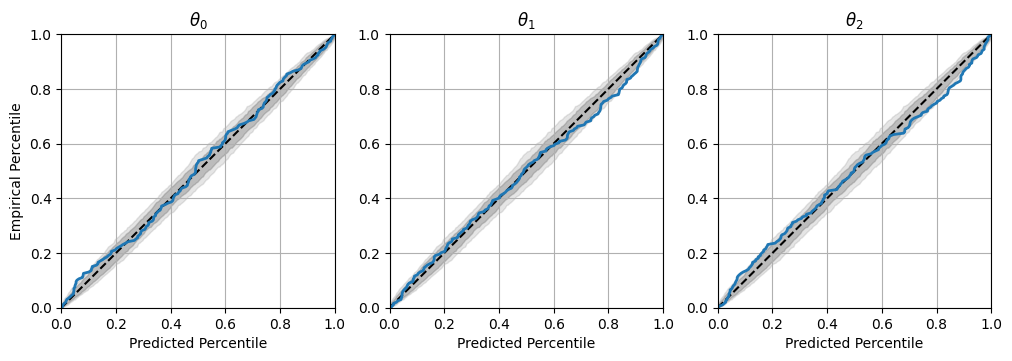

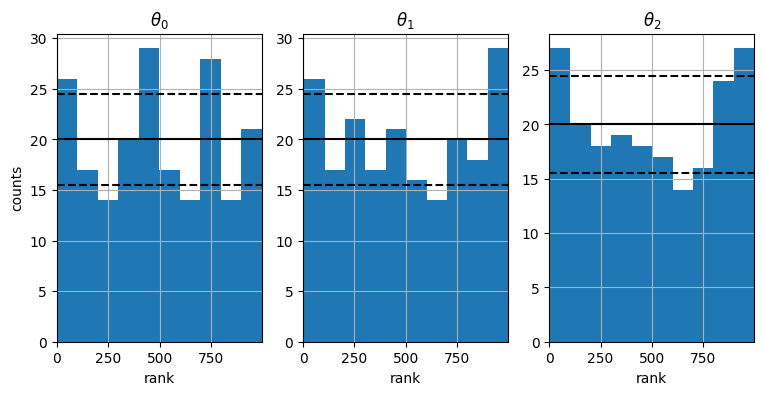

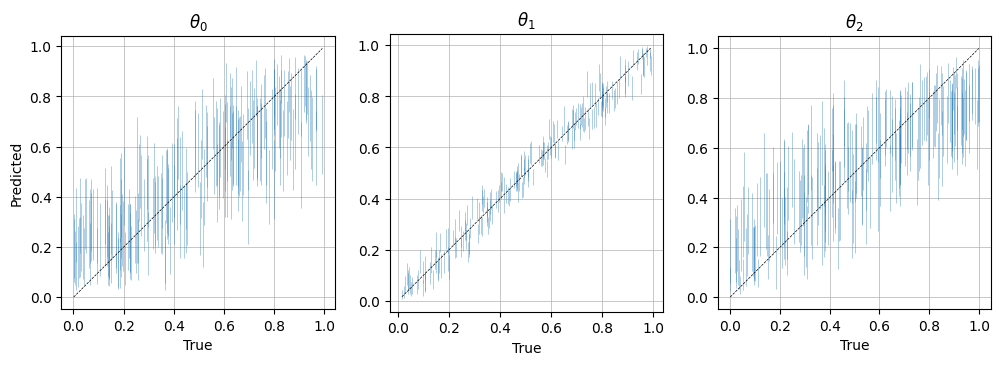

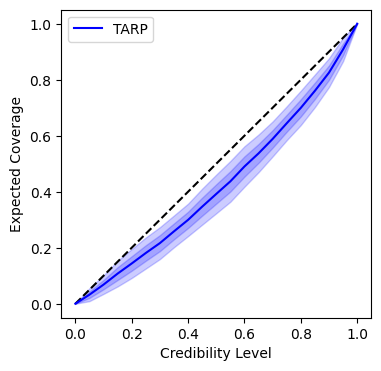

In [12]:
# Drawing samples for each posterior in the ensemble
# First the first MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x=x, theta=theta
)

  0%|                                                                                                                                     | 0/200 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2519.53it/s]

  0%|                                                                                                                                     | 0/100 [00:00<?, ?it/s]

 17%|████████████████████▉                                                                                                      | 17/100 [00:00<00:00, 169.00it/s]

 35%|███████████████████████████████████████████                                                                                | 35/100 [00:00<00:00, 170.39it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                         | 53/100 [00:00<00:00, 172.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▌                                  | 72/100 [00:00<00:00, 176.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 90/100 [00:00<00:00, 175.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.79it/s]

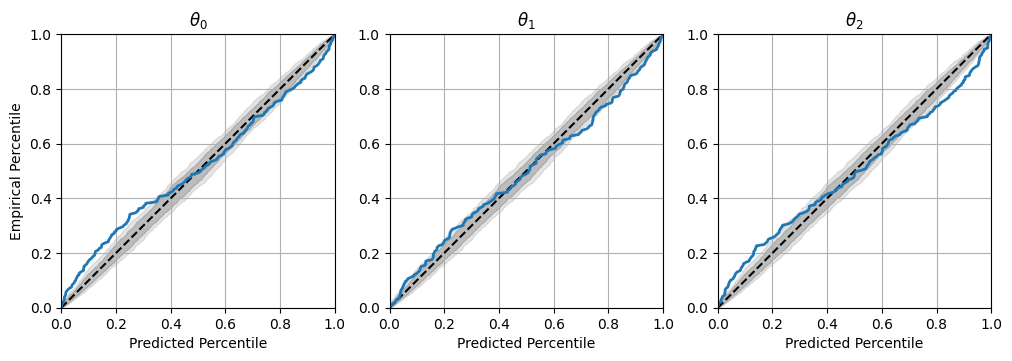

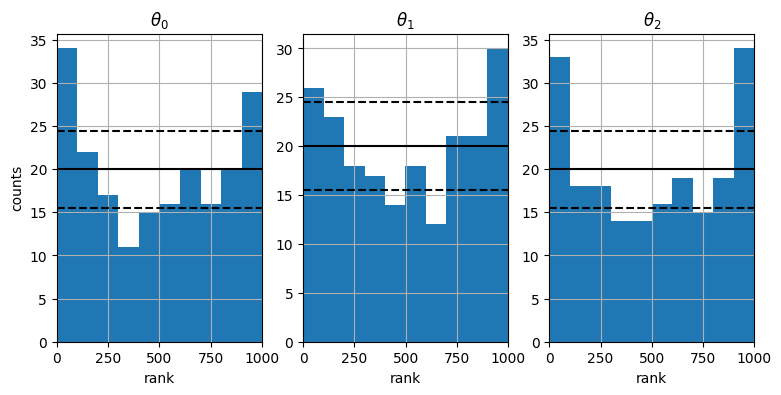

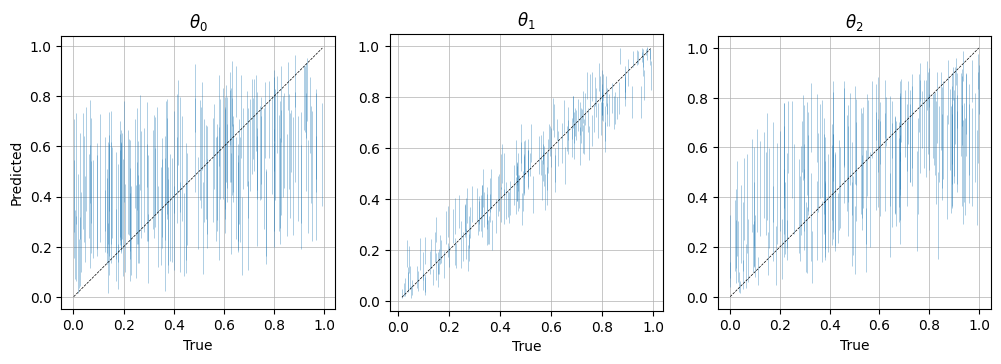

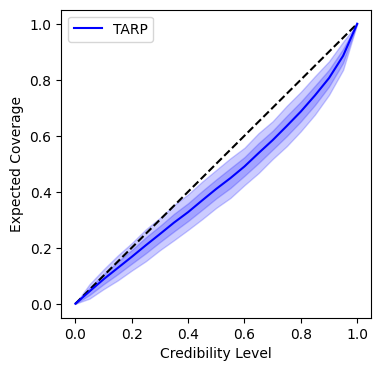

In [13]:
# Then for the MDN
fig = metric(
    posterior=posterior_ensemble.posteriors[2],
    x=x, theta=theta
)

From these results, we see that we are largely consistent and calibrated in the univariate coverage, with some slight negative bias shown in the multivariate coverage. It looks like the MAF model has slightly better constraints than the MDN model, while retaining the same calibration.

## Toy NLE
This example uses the same dataset as the previous SNPE example, but uses a likelihood estimation model instead of an amortized posterior estimation.

In [14]:
# create the same synthetic catalog as the previous example
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 4321
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

In [15]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NLE', model='made', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [16]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE


INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 20

 Training neural network. Epochs trained: 40

 Training neural network. Epochs trained: 60

 Training neural network. Epochs trained: 80

 Training neural network. Epochs trained: 99

 Training neural network. Epochs trained: 119

 Training neural network. Epochs trained: 138

 Training neural network. Epochs trained: 157

 Training neural network. Epochs trained: 176

 Training neural network. Epochs trained: 195

 Training neural network. Epochs trained: 214

 Training neural network. Epochs trained: 233

 Training neural network. Epochs trained: 252

 Training neural network. Epochs trained: 271

 Training neural network. Epochs trained: 290

 Training neural network. Epochs trained: 310

 Training neural network. Epochs trained: 330

 Training neural network. Epochs trained: 350

 Training neural network. Epochs trained: 370

 Training neural network. Epochs trained: 389

 Training neural network. Epochs trained: 409

 Training neural network. Epochs trained: 429

 Training neural network. Epochs trained: 448

 Training neural network. Epochs trained: 468

 Training neural network. Epochs trained: 488

 Training neural network. Epochs trained: 508

 Training neural network. Epochs trained: 527

 Training neural network. Epochs trained: 547

 Training neural network. Epochs trained: 567

 Training neural network. Epochs trained: 587

 Training neural network. Epochs trained: 607

 Training neural network. Epochs trained: 627

 Training neural network. Epochs trained: 647

 Training neural network. Epochs trained: 667

 Training neural network. Epochs trained: 687

 Training neural network. Epochs trained: 707

 Training neural network. Epochs trained: 727

 Training neural network. Epochs trained: 747

 Training neural network. Epochs trained: 768

 Training neural network. Epochs trained: 789

 Training neural network. Epochs trained: 809

 Training neural network. Epochs trained: 830

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 844 epochs.

 Training neural network. Epochs trained: 26

 Training neural network. Epochs trained: 52

 Training neural network. Epochs trained: 78

 Training neural network. Epochs trained: 104

 Training neural network. Epochs trained: 130

 Training neural network. Epochs trained: 157

 Training neural network. Epochs trained: 184

 Training neural network. Epochs trained: 211

 Training neural network. Epochs trained: 238

 Training neural network. Epochs trained: 266

 Training neural network. Epochs trained: 293

 Training neural network. Epochs trained: 321

 Training neural network. Epochs trained: 349

 Training neural network. Epochs trained: 377

 Training neural network. Epochs trained: 405

 Training neural network. Epochs trained: 433

INFO:root:It took 12.312649965286255 seconds to train models.


 Neural network successfully converged after 447 epochs.

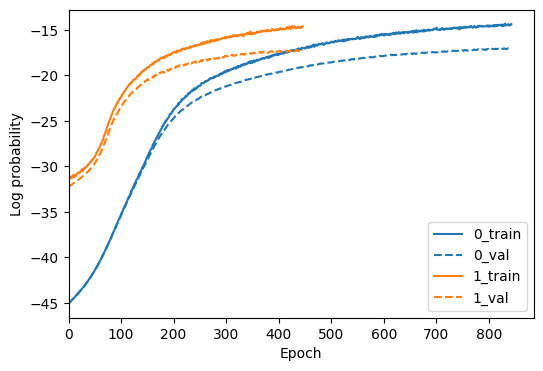

In [17]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(-1.0*np.array(m['training_loss']), ls='-', label=f"{i}_train", c=c[i])
    ax.plot(-1.0*np.array(m['validation_loss']), ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [18]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind], 
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples, 
    x[ind]
).detach().cpu().numpy()

Generating 6 MCMC inits via resample strategy:   0%|          | 0/6 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/2052 [00:00<?, ?it/s]

Generating 6 MCMC inits via resample strategy:   0%|          | 0/6 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/1950 [00:00<?, ?it/s]

Note: Amortized liklihood estimators do not directly estimate the posterior, but instead build a model for the relative likelihood. This can be combined with a prior to estimate the potential function, which is proportional to the log_probability up to a normalizing constant. Hence, we use MCMC sampling for SNLE models to probe the posterior distribution.

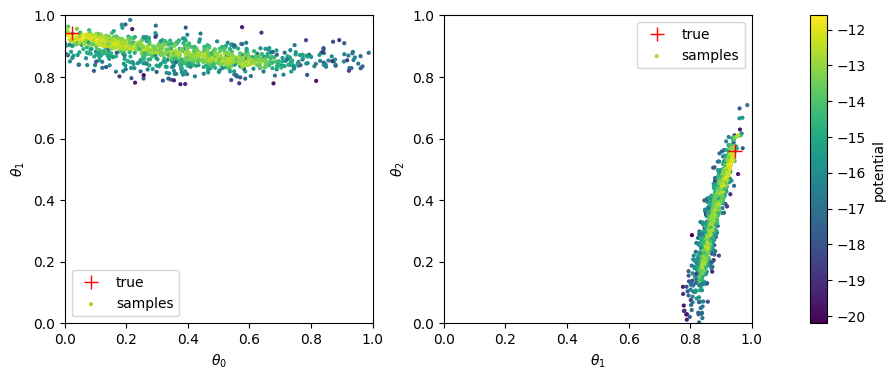

In [19]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

  0%|                                                                                                                                     | 0/200 [00:00<?, ?it/s]

  0%|▋                                                                                                                            | 1/200 [00:01<03:34,  1.08s/it]

  1%|█▎                                                                                                                           | 2/200 [00:01<02:41,  1.23it/s]

  2%|█▉                                                                                                                           | 3/200 [00:03<04:16,  1.30s/it]

  2%|██▌                                                                                                                          | 4/200 [00:04<03:50,  1.17s/it]

  2%|███▏                                                                                                                         | 5/200 [00:06<04:44,  1.46s/it]

  3%|███▊                                                                                                                         | 6/200 [00:07<03:49,  1.18s/it]

  4%|████▍                                                                                                                        | 7/200 [00:08<03:35,  1.11s/it]

  4%|█████                                                                                                                        | 8/200 [00:08<03:05,  1.03it/s]

  4%|█████▋                                                                                                                       | 9/200 [00:09<02:37,  1.22it/s]

  5%|██████▏                                                                                                                     | 10/200 [00:10<03:18,  1.05s/it]

  6%|██████▊                                                                                                                     | 11/200 [00:12<04:00,  1.27s/it]

  6%|███████▍                                                                                                                    | 12/200 [00:13<03:55,  1.25s/it]

  6%|████████                                                                                                                    | 13/200 [00:14<03:12,  1.03s/it]

  7%|████████▋                                                                                                                   | 14/200 [00:15<03:18,  1.07s/it]

  8%|█████████▎                                                                                                                  | 15/200 [00:17<03:49,  1.24s/it]

  8%|█████████▉                                                                                                                  | 16/200 [00:18<03:29,  1.14s/it]

  8%|██████████▌                                                                                                                 | 17/200 [00:19<03:48,  1.25s/it]

  9%|███████████▏                                                                                                                | 18/200 [00:20<03:18,  1.09s/it]

 10%|███████████▊                                                                                                                | 19/200 [00:20<02:49,  1.07it/s]

 10%|████████████▍                                                                                                               | 20/200 [00:21<02:46,  1.08it/s]

 10%|█████████████                                                                                                               | 21/200 [00:22<02:39,  1.12it/s]

 11%|█████████████▋                                                                                                              | 22/200 [00:22<02:12,  1.34it/s]

 12%|██████████████▎                                                                                                             | 23/200 [00:23<02:05,  1.41it/s]

 12%|██████████████▉                                                                                                             | 24/200 [00:24<02:31,  1.16it/s]

 12%|███████████████▌                                                                                                            | 25/200 [00:25<02:45,  1.06it/s]

 13%|████████████████                                                                                                            | 26/200 [00:27<02:49,  1.03it/s]

 14%|████████████████▋                                                                                                           | 27/200 [00:27<02:44,  1.05it/s]

 14%|█████████████████▎                                                                                                          | 28/200 [00:28<02:22,  1.20it/s]

 14%|█████████████████▉                                                                                                          | 29/200 [00:28<02:07,  1.34it/s]

 15%|██████████████████▌                                                                                                         | 30/200 [00:29<02:13,  1.28it/s]

 16%|███████████████████▏                                                                                                        | 31/200 [00:30<02:08,  1.32it/s]

 16%|███████████████████▊                                                                                                        | 32/200 [00:31<02:26,  1.15it/s]

 16%|████████████████████▍                                                                                                       | 33/200 [00:32<02:35,  1.07it/s]

 17%|█████████████████████                                                                                                       | 34/200 [00:33<02:23,  1.15it/s]

 18%|█████████████████████▋                                                                                                      | 35/200 [00:34<02:13,  1.24it/s]

 18%|██████████████████████▎                                                                                                     | 36/200 [00:35<02:18,  1.18it/s]

 18%|██████████████████████▉                                                                                                     | 37/200 [00:35<02:07,  1.28it/s]

 19%|███████████████████████▌                                                                                                    | 38/200 [00:37<02:32,  1.06it/s]

 20%|████████████████████████▏                                                                                                   | 39/200 [00:38<02:41,  1.00s/it]

 20%|████████████████████████▊                                                                                                   | 40/200 [00:40<03:27,  1.30s/it]

 20%|█████████████████████████▍                                                                                                  | 41/200 [00:41<03:26,  1.30s/it]

 21%|██████████████████████████                                                                                                  | 42/200 [00:42<03:19,  1.27s/it]

 22%|██████████████████████████▋                                                                                                 | 43/200 [00:43<02:56,  1.12s/it]

 22%|███████████████████████████▎                                                                                                | 44/200 [00:44<02:38,  1.02s/it]

 22%|███████████████████████████▉                                                                                                | 45/200 [00:44<02:12,  1.17it/s]

 23%|████████████████████████████▌                                                                                               | 46/200 [00:45<01:54,  1.35it/s]

 24%|█████████████████████████████▏                                                                                              | 47/200 [00:45<01:56,  1.31it/s]

 24%|█████████████████████████████▊                                                                                              | 48/200 [00:46<02:02,  1.24it/s]

 24%|██████████████████████████████▍                                                                                             | 49/200 [00:47<02:04,  1.21it/s]

 25%|███████████████████████████████                                                                                             | 50/200 [00:48<01:47,  1.40it/s]

 26%|███████████████████████████████▌                                                                                            | 51/200 [00:49<02:33,  1.03s/it]

 26%|████████████████████████████████▏                                                                                           | 52/200 [00:50<02:14,  1.10it/s]

 26%|████████████████████████████████▊                                                                                           | 53/200 [00:51<02:29,  1.01s/it]

 27%|█████████████████████████████████▍                                                                                          | 54/200 [00:53<02:49,  1.16s/it]

 28%|██████████████████████████████████                                                                                          | 55/200 [00:55<03:24,  1.41s/it]

 28%|██████████████████████████████████▋                                                                                         | 56/200 [00:56<03:12,  1.34s/it]

 28%|███████████████████████████████████▎                                                                                        | 57/200 [00:57<03:01,  1.27s/it]

 29%|███████████████████████████████████▉                                                                                        | 58/200 [00:58<02:37,  1.11s/it]

 30%|████████████████████████████████████▌                                                                                       | 59/200 [00:59<02:53,  1.23s/it]

 30%|█████████████████████████████████████▏                                                                                      | 60/200 [01:02<03:56,  1.69s/it]

 30%|█████████████████████████████████████▊                                                                                      | 61/200 [01:03<03:27,  1.49s/it]

 31%|██████████████████████████████████████▍                                                                                     | 62/200 [01:05<03:27,  1.51s/it]

 32%|███████████████████████████████████████                                                                                     | 63/200 [01:06<03:22,  1.48s/it]

 32%|███████████████████████████████████████▋                                                                                    | 64/200 [01:07<03:02,  1.34s/it]

 32%|████████████████████████████████████████▎                                                                                   | 65/200 [01:08<02:36,  1.16s/it]

 33%|████████████████████████████████████████▉                                                                                   | 66/200 [01:08<02:11,  1.02it/s]

 34%|█████████████████████████████████████████▌                                                                                  | 67/200 [01:09<02:04,  1.07it/s]

 34%|██████████████████████████████████████████▏                                                                                 | 68/200 [01:10<02:03,  1.07it/s]

 34%|██████████████████████████████████████████▊                                                                                 | 69/200 [01:12<02:22,  1.08s/it]

 35%|███████████████████████████████████████████▍                                                                                | 70/200 [01:12<02:09,  1.01it/s]

 36%|████████████████████████████████████████████                                                                                | 71/200 [01:13<01:56,  1.11it/s]

 36%|████████████████████████████████████████████▋                                                                               | 72/200 [01:14<02:03,  1.03it/s]

 36%|█████████████████████████████████████████████▎                                                                              | 73/200 [01:16<02:41,  1.27s/it]

 37%|█████████████████████████████████████████████▉                                                                              | 74/200 [01:17<02:15,  1.07s/it]

 38%|██████████████████████████████████████████████▌                                                                             | 75/200 [01:18<02:30,  1.20s/it]

 38%|███████████████████████████████████████████████                                                                             | 76/200 [01:20<02:43,  1.32s/it]

 38%|███████████████████████████████████████████████▋                                                                            | 77/200 [01:22<02:54,  1.42s/it]

 39%|████████████████████████████████████████████████▎                                                                           | 78/200 [01:22<02:31,  1.24s/it]

 40%|████████████████████████████████████████████████▉                                                                           | 79/200 [01:24<02:26,  1.21s/it]

 40%|█████████████████████████████████████████████████▌                                                                          | 80/200 [01:27<03:45,  1.88s/it]

 40%|██████████████████████████████████████████████████▏                                                                         | 81/200 [01:28<02:59,  1.51s/it]

 41%|██████████████████████████████████████████████████▊                                                                         | 82/200 [01:29<02:39,  1.35s/it]

 42%|███████████████████████████████████████████████████▍                                                                        | 83/200 [01:30<02:30,  1.28s/it]

 42%|████████████████████████████████████████████████████                                                                        | 84/200 [01:33<03:23,  1.75s/it]

 42%|████████████████████████████████████████████████████▋                                                                       | 85/200 [01:34<03:19,  1.74s/it]

 43%|█████████████████████████████████████████████████████▎                                                                      | 86/200 [01:36<03:21,  1.77s/it]

 44%|█████████████████████████████████████████████████████▉                                                                      | 87/200 [01:37<02:59,  1.59s/it]

 44%|██████████████████████████████████████████████████████▌                                                                     | 88/200 [01:38<02:32,  1.37s/it]

 44%|███████████████████████████████████████████████████████▏                                                                    | 89/200 [01:40<02:53,  1.56s/it]

 45%|███████████████████████████████████████████████████████▊                                                                    | 90/200 [01:41<02:17,  1.25s/it]

 46%|████████████████████████████████████████████████████████▍                                                                   | 91/200 [01:41<01:55,  1.06s/it]

 46%|█████████████████████████████████████████████████████████                                                                   | 92/200 [01:42<01:59,  1.10s/it]

 46%|█████████████████████████████████████████████████████████▋                                                                  | 93/200 [01:43<01:50,  1.03s/it]

 47%|██████████████████████████████████████████████████████████▎                                                                 | 94/200 [01:44<01:52,  1.06s/it]

 48%|██████████████████████████████████████████████████████████▉                                                                 | 95/200 [01:45<01:36,  1.09it/s]

 48%|███████████████████████████████████████████████████████████▌                                                                | 96/200 [01:47<01:54,  1.10s/it]

 48%|████████████████████████████████████████████████████████████▏                                                               | 97/200 [01:48<02:15,  1.31s/it]

 49%|████████████████████████████████████████████████████████████▊                                                               | 98/200 [01:50<02:10,  1.28s/it]

 50%|█████████████████████████████████████████████████████████████▍                                                              | 99/200 [01:51<01:57,  1.16s/it]

 50%|█████████████████████████████████████████████████████████████▌                                                             | 100/200 [01:51<01:45,  1.05s/it]

 50%|██████████████████████████████████████████████████████████████                                                             | 101/200 [01:52<01:30,  1.09it/s]

 51%|██████████████████████████████████████████████████████████████▋                                                            | 102/200 [01:53<01:32,  1.06it/s]

 52%|███████████████████████████████████████████████████████████████▎                                                           | 103/200 [01:54<01:36,  1.00it/s]

 52%|███████████████████████████████████████████████████████████████▉                                                           | 104/200 [01:55<01:30,  1.06it/s]

 52%|████████████████████████████████████████████████████████████████▌                                                          | 105/200 [01:55<01:19,  1.19it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                         | 106/200 [01:58<01:53,  1.20s/it]

 54%|█████████████████████████████████████████████████████████████████▊                                                         | 107/200 [01:58<01:44,  1.12s/it]

 54%|██████████████████████████████████████████████████████████████████▍                                                        | 108/200 [02:00<01:50,  1.21s/it]

 55%|███████████████████████████████████████████████████████████████████                                                        | 109/200 [02:50<24:07, 15.90s/it]

 55%|███████████████████████████████████████████████████████████████████▋                                                       | 110/200 [02:51<17:05, 11.40s/it]

 56%|████████████████████████████████████████████████████████████████████▎                                                      | 111/200 [02:52<12:06,  8.17s/it]

 56%|████████████████████████████████████████████████████████████████████▉                                                      | 112/200 [02:55<09:41,  6.61s/it]

 56%|█████████████████████████████████████████████████████████████████████▍                                                     | 113/200 [02:55<07:02,  4.86s/it]

 57%|██████████████████████████████████████████████████████████████████████                                                     | 114/200 [02:57<05:28,  3.82s/it]

 57%|██████████████████████████████████████████████████████████████████████▋                                                    | 115/200 [02:57<04:03,  2.86s/it]

 58%|███████████████████████████████████████████████████████████████████████▎                                                   | 116/200 [02:59<03:34,  2.55s/it]

 58%|███████████████████████████████████████████████████████████████████████▉                                                   | 117/200 [03:00<02:55,  2.11s/it]

 59%|████████████████████████████████████████████████████████████████████████▌                                                  | 118/200 [03:01<02:21,  1.72s/it]

 60%|█████████████████████████████████████████████████████████████████████████▏                                                 | 119/200 [03:02<01:51,  1.37s/it]

 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 120/200 [03:03<01:46,  1.33s/it]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                | 121/200 [03:04<01:39,  1.26s/it]

 61%|███████████████████████████████████████████████████████████████████████████                                                | 122/200 [03:05<01:41,  1.30s/it]

 62%|███████████████████████████████████████████████████████████████████████████▋                                               | 123/200 [03:06<01:26,  1.12s/it]

 62%|████████████████████████████████████████████████████████████████████████████▎                                              | 124/200 [03:07<01:28,  1.16s/it]

 62%|████████████████████████████████████████████████████████████████████████████▉                                              | 125/200 [03:09<01:43,  1.38s/it]

 63%|█████████████████████████████████████████████████████████████████████████████▍                                             | 126/200 [03:10<01:22,  1.12s/it]

 64%|██████████████████████████████████████████████████████████████████████████████                                             | 127/200 [03:10<01:11,  1.03it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▋                                            | 128/200 [03:12<01:17,  1.08s/it]

 64%|███████████████████████████████████████████████████████████████████████████████▎                                           | 129/200 [03:13<01:20,  1.14s/it]

 65%|███████████████████████████████████████████████████████████████████████████████▉                                           | 130/200 [03:14<01:08,  1.02it/s]

 66%|████████████████████████████████████████████████████████████████████████████████▌                                          | 131/200 [03:14<01:07,  1.03it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▏                                         | 132/200 [03:15<00:56,  1.21it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                         | 133/200 [03:16<00:53,  1.25it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▍                                        | 134/200 [03:16<00:49,  1.33it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████                                        | 135/200 [03:17<00:46,  1.40it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▋                                       | 136/200 [03:18<00:57,  1.11it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                      | 137/200 [03:20<01:08,  1.08s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████▊                                      | 138/200 [03:21<01:01,  1.01it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████▍                                     | 139/200 [03:22<01:00,  1.01it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 140/200 [03:22<00:56,  1.06it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                    | 141/200 [03:23<00:52,  1.13it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▎                                   | 142/200 [03:24<00:55,  1.05it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████▉                                   | 143/200 [03:25<00:58,  1.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████▌                                  | 144/200 [03:28<01:14,  1.34s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                 | 145/200 [03:29<01:18,  1.43s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▊                                 | 146/200 [03:30<01:03,  1.18s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████▍                                | 147/200 [03:31<01:04,  1.21s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 148/200 [03:34<01:23,  1.61s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                               | 149/200 [03:35<01:19,  1.56s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 150/200 [03:36<01:06,  1.34s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████▊                              | 151/200 [03:37<00:56,  1.15s/it]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▍                             | 152/200 [03:38<00:52,  1.09s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                             | 153/200 [03:38<00:43,  1.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▋                            | 154/200 [03:39<00:43,  1.06it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▎                           | 155/200 [03:39<00:34,  1.29it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▉                           | 156/200 [03:40<00:35,  1.23it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 157/200 [03:41<00:32,  1.31it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 158/200 [03:43<00:43,  1.04s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 159/200 [03:43<00:39,  1.03it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 160/200 [03:44<00:33,  1.18it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                        | 161/200 [03:46<00:46,  1.20s/it]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 162/200 [03:48<00:50,  1.33s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 163/200 [03:48<00:42,  1.15s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 164/200 [03:50<00:41,  1.15s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 165/200 [03:50<00:35,  1.03s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████                     | 166/200 [03:53<00:49,  1.47s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 167/200 [03:54<00:41,  1.25s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 168/200 [03:57<01:05,  2.06s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 169/200 [03:58<00:48,  1.58s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 170/200 [03:59<00:38,  1.30s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 171/200 [04:00<00:34,  1.18s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 172/200 [04:01<00:35,  1.26s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 173/200 [04:02<00:34,  1.27s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                | 174/200 [04:05<00:42,  1.65s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 175/200 [04:06<00:34,  1.38s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 176/200 [04:06<00:29,  1.21s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 177/200 [04:08<00:29,  1.27s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 178/200 [04:09<00:25,  1.15s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 179/200 [04:09<00:20,  1.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 180/200 [04:10<00:19,  1.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 181/200 [04:11<00:18,  1.02it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 182/200 [04:12<00:17,  1.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 183/200 [04:14<00:20,  1.19s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 184/200 [04:16<00:22,  1.44s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 185/200 [04:17<00:20,  1.39s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 186/200 [04:20<00:27,  1.93s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 187/200 [04:22<00:25,  1.92s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 188/200 [04:25<00:25,  2.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 189/200 [04:26<00:20,  1.89s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 190/200 [04:28<00:17,  1.76s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 191/200 [04:29<00:14,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 192/200 [04:31<00:13,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 193/200 [04:32<00:10,  1.55s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 194/200 [04:32<00:07,  1.23s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 195/200 [04:33<00:05,  1.11s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 196/200 [04:36<00:05,  1.49s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 197/200 [04:36<00:03,  1.26s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 198/200 [04:37<00:02,  1.09s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 199/200 [04:38<00:01,  1.14s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [04:39<00:00,  1.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [04:39<00:00,  1.40s/it]

  0%|                                                                                                                                     | 0/100 [00:00<?, ?it/s]

 15%|██████████████████▍                                                                                                        | 15/100 [00:00<00:00, 141.33it/s]

 30%|████████████████████████████████████▉                                                                                      | 30/100 [00:00<00:00, 145.14it/s]

 47%|█████████████████████████████████████████████████████████▊                                                                 | 47/100 [00:00<00:00, 154.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████▉                                           | 65/100 [00:00<00:00, 163.39it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████                     | 83/100 [00:00<00:00, 166.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 163.32it/s]

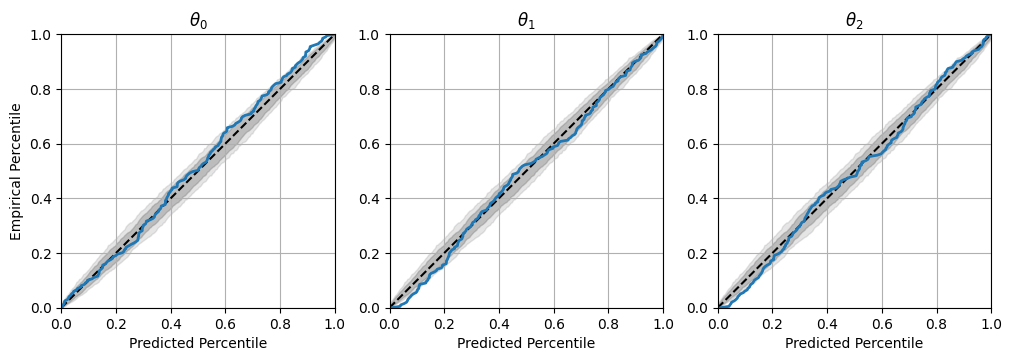

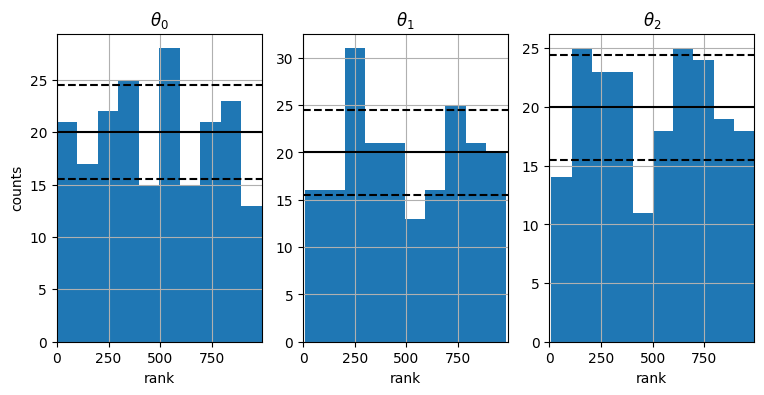

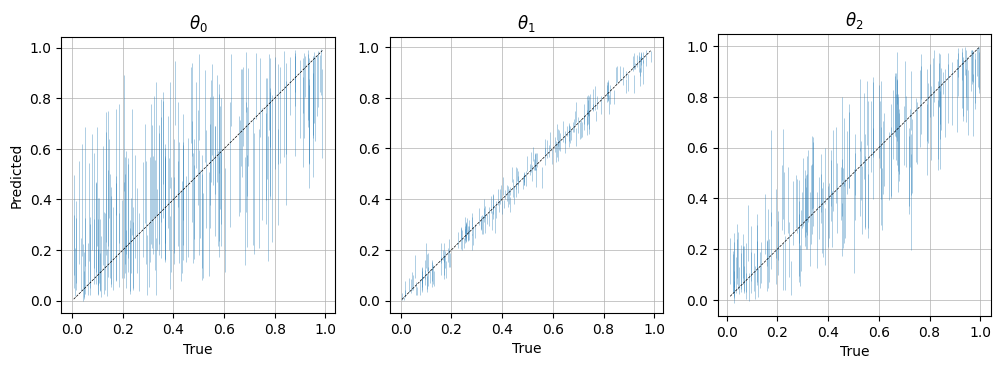

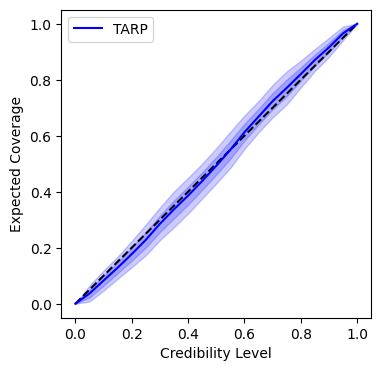

In [20]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='vi',
    sample_params={'dist': 'maf', 'n_particles': 32, 'learning_rate': 1e-2},
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"]
)

# Drawing samples from the ensemble posterior
fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

Looks like we're well-calibrated in both univariate and multivariate tests, with much tighter constraints on $\theta_1$ than the SNPE!